<a href="https://colab.research.google.com/github/chimera-org/chimera_v2.0/blob/main/notebooks/eegencoder_experiments/02_train_eegencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Clone your GitHub repository
!git clone https://github.com/chimera-org/chimera_v2.0/

print("✅ Repository cloned.")

Cloning into 'chimera_v2.0'...
remote: Enumerating objects: 1704, done.
remote: Counting objects: 100% (249/249), done.
remote: Compressing objects: 100% (144/144), done.
remote: Total 1704 (delta 182), reused 105 (delta 105), pack-reused 1455 (from 2)
Receiving objects: 100% (1704/1704), 970.39 KiB | 19.80 MiB/s, done.
Resolving deltas: 100% (868/868), done.
✅ Repository cloned.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Setup Environment for EEGEncoder Training

# 1. Install dependencies
!pip install torch torchvision tqdm scikit-learn matplotlib mne numpy scipy --quiet

# 2. Add src to Python path
import sys
import os

SRC_PATH = "/content/chimera_v2.0/src"
if SRC_PATH not in sys.path:
    sys.path.append(SRC_PATH)

# 3. Verify path
assert os.path.exists(SRC_PATH), f"Path not found: {SRC_PATH}"

# 4. Import modules
import torch
from eegencoder.model import EEGEncoder
from eegencoder.train import train_model, get_loso_dataloaders, run_loso_cross_validation
from eegencoder.data_loader import BCIC4_2A_Loader
import matplotlib.pyplot as plt

# 5. Verify setup
print("✅ Environment ready")
print(f"📦 PyTorch {torch.__version__}")
print(f"🔥 CUDA: {torch.cuda.is_available()}")
print(f"📁 Path: {SRC_PATH}")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 86.7 MB/s eta 0:00:00
✅ Environment ready
📦 PyTorch 2.9.0+cu126
🔥 CUDA: True
📁 Path: /content/chimera_v2.0/src


In [4]:
# Create and Save Preprocessed Data

import os
import numpy as np
from eegencoder.data_loader import BCIC4_2A_Loader

# Path to your extracted GDF files
GDF_PATH = "/content/drive/MyDrive/Motor_Imagery_Datasets/OpenBCI/BCI_cIV_2a/BCI_IV_2a/"

# Where to save processed NPY files
OUTPUT_DIR = "/content/drive/MyDrive/chimera_v2.0/data/bcic4_2a_processed/"

# Create output directory
os.makedirs(OUTPUT_DIR, exist_ok=True)
print(f"📁 Output directory: {OUTPUT_DIR}")

# Initialize loader
loader = BCIC4_2A_Loader(GDF_PATH)

print("="*50)
print("SAVING PREPROCESSED DATA")
print("="*50)

# Save all subjects
for subj_id in range(1, 10):
    print(f"Processing subject {subj_id:02d}...")

    X, y = loader.load_subject(subj_id, training=True)

    np.save(f"{OUTPUT_DIR}subject_{subj_id:02d}_X.npy", X)
    np.save(f"{OUTPUT_DIR}subject_{subj_id:02d}_y.npy", y)

    print(f"  ✅ Saved: X={X.shape}, labels={np.bincount(y)}")

print(f"\n🎉 Done! Data saved to: {OUTPUT_DIR}")

# Verify
files = os.listdir(OUTPUT_DIR)
print(f"Found {len(files)} files: {sorted(files)}")

📁 Output directory: /content/drive/MyDrive/chimera_v2.0/data/bcic4_2a_processed/
SAVING PREPROCESSED DATA
Processing subject 01...
  ✅ Saved: X=(287, 22, 1000), labels=[71 72 72 72]
Processing subject 02...
  ✅ Saved: X=(287, 22, 1000), labels=[72 72 71 72]
Processing subject 03...
  ✅ Saved: X=(287, 22, 1000), labels=[72 72 71 72]
Processing subject 04...
  ✅ Saved: X=(287, 22, 1000), labels=[71 72 72 72]
Processing subject 05...
  ✅ Saved: X=(287, 22, 1000), labels=[72 72 71 72]
Processing subject 06...
  ✅ Saved: X=(287, 22, 1000), labels=[72 72 71 72]
Processing subject 07...
  ✅ Saved: X=(287, 22, 1000), labels=[72 72 71 72]
Processing subject 08...
  ✅ Saved: X=(287, 22, 1000), labels=[72 72 71 72]
Processing subject 09...
  ✅ Saved: X=(287, 22, 1000), labels=[72 72 71 72]

🎉 Done! Data saved to: /content/drive/MyDrive/chimera_v2.0/data/bcic4_2a_processed/
Found 20 files: ['subject_01_X.npy', 'subject_01_train_X.npy', 'subject_01_train_y.npy', 'subject_01_y.npy', 'subject_02_X.np

In [5]:
# Verify Preprocessed Data Exists
DATA_DIR = "/content/drive/MyDrive/chimera_v2.0/data/bcic4_2a_processed/"

import os

print(f"Checking: {DATA_DIR}")
print("="*50)

if not os.path.exists(DATA_DIR):
    print(f"❌ Directory does NOT exist: {DATA_DIR}")
else:
    files = os.listdir(DATA_DIR)
    npy_files = [f for f in files if f.endswith('.npy')]
    print(f"✅ Found {len(npy_files)} .npy files")

    # Show first few
    print("\nFirst 10 files:")
    for f in sorted(npy_files)[:10]:
        print(f"  - {f}")

    # Check if we have both X and y for subject 01
    x_files = [f for f in npy_files if 'X.npy' in f]
    y_files = [f for f in npy_files if 'y.npy' in f]
    print(f"\nX files: {len(x_files)}, Y files: {len(y_files)}")

# If empty, you need to run the preprocessing cell (Cell 6) in 01_load_bcic4_2a.ipynb

Checking: /content/drive/MyDrive/chimera_v2.0/data/bcic4_2a_processed/
✅ Found 20 .npy files

First 10 files:
  - subject_01_X.npy
  - subject_01_train_X.npy
  - subject_01_train_y.npy
  - subject_01_y.npy
  - subject_02_X.npy
  - subject_02_y.npy
  - subject_03_X.npy
  - subject_03_y.npy
  - subject_04_X.npy
  - subject_04_y.npy

X files: 10, Y files: 10


In [8]:
# SIMPLIFIED DSTS Architecture

import torch
import torch.nn as nn
import numpy as np

class SimplifiedDSTS(nn.Module):
    """DSTS with reduced complexity for 22-channel EEG"""
    def __init__(self, num_classes=4, num_channels=22, num_branches=2, transformer_layers=1):
        super().__init__()

        self.num_branches = num_branches

        # Multi-scale branch structure (simplified)
        self.branches = nn.ModuleList([
            nn.Sequential(
                # Dynamic Scalable Temporal Sensing (DSTS) block
                nn.Conv1d(num_channels, 32, kernel_size=125, stride=1, padding=62, bias=False),
                nn.BatchNorm1d(32),
                nn.ELU(),
                nn.Dropout(0.5)  # Stronger dropout
            ) for _ in range(num_branches)
        ])

        # Multi-scale kernels per branch
        self.scale_convs = nn.ModuleList([
            nn.ModuleList([
                nn.Conv1d(32, 16, kernel_size=k, padding=(k-1)//2, bias=False)
                for k in [3, 5, 7, 9]
            ]) for _ in range(num_branches)
        ])

        # Simplified transformer (one layer)
        self.transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(
                d_model=64 * num_branches,  # Concatenated features
                nhead=4,
                dim_feedforward=128,
                dropout=0.5,
                batch_first=True
            ),
            num_layers=transformer_layers
        )

        # Global average pooling + classifier
        self.gap = nn.AdaptiveAvgPool1d(1)
        self.classifier = nn.Linear(64 * num_branches, num_classes)

        # Initialize weights
        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Conv1d):
            nn.init.xavier_uniform_(m.weight)
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.BatchNorm1d):
            nn.init.constant_(m.weight, 1)
            nn.init.constant_(m.bias, 0)

    def forward(self, x):
        # x: (B, C, T) -> (B, 22, 1000)
        batch_size = x.size(0)

        # Multi-branch processing
        branch_outputs = []
        for i in range(self.num_branches):
            # Temporal sensing
            temp_out = self.branches[i](x)  # (B, 32, T)

            # Multi-scale feature extraction
            scale_features = []
            for conv in self.scale_convs[i]:
                scale_features.append(conv(temp_out))

            # Concatenate scales
            branch_feat = torch.cat(scale_features, dim=1)  # (B, 64, T)
            branch_outputs.append(branch_feat)

        # Concatenate branches
        features = torch.cat(branch_outputs, dim=1)  # (B, 128, T)

        # Reshape for transformer: (B, T, C)
        features = features.transpose(1, 2)  # (B, T, 128)

        # Transformer encoding
        transformed = self.transformer(features)  # (B, T, 128)

        # Global average pooling over time
        pooled = self.gap(transformed.transpose(1, 2)).squeeze(-1)  # (B, 128)

        # Classification
        return self.classifier(pooled)

def get_model_simple(num_classes=4, pi_compatibility=True):
    """Factory for simplified DSTS"""
    return SimplifiedDSTS(num_classes=num_classes, num_branches=2, transformer_layers=1)

# Quick test
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = get_model_simple(num_classes=4).to(device)

print(f"🧠 Simplified DSTS: {sum(p.numel() for p in model.parameters())/1e6:.2f}M parameters")
print(f"Device: {device}")

# Test forward pass
x_test = torch.randn(2, 22, 1000).to(device)
output = model(x_test)
print(f"Forward pass: {x_test.shape} -> {output.shape} ✅")

🧠 Simplified DSTS: 0.30M parameters
Device: cuda
Forward pass: torch.Size([2, 22, 1000]) -> torch.Size([2, 4]) ✅


Loaded: Train=(2296, 22, 1000), Test=(287, 22, 1000)
🧠 Training Simplified DSTS
Parameters: 0.30M
Data range: [-3.821, 3.944]

Epoch 05/50 | Train: 0.3118 | Val: 0.2822 | Best: 0.2822
Epoch 10/50 | Train: 0.3193 | Val: 0.2648 | Best: 0.2962
Epoch 15/50 | Train: 0.3563 | Val: 0.2718 | Best: 0.2962
Epoch 20/50 | Train: 0.3632 | Val: 0.2962 | Best: 0.3101
Epoch 25/50 | Train: 0.4111 | Val: 0.2683 | Best: 0.3171
Epoch 30/50 | Train: 0.4220 | Val: 0.2857 | Best: 0.3171
Epoch 35/50 | Train: 0.4412 | Val: 0.2753 | Best: 0.3171
Epoch 40/50 | Train: 0.4730 | Val: 0.2578 | Best: 0.3240
Epoch 45/50 | Train: 0.4861 | Val: 0.2822 | Best: 0.3275
Epoch 50/50 | Train: 0.4830 | Val: 0.2857 | Best: 0.3275


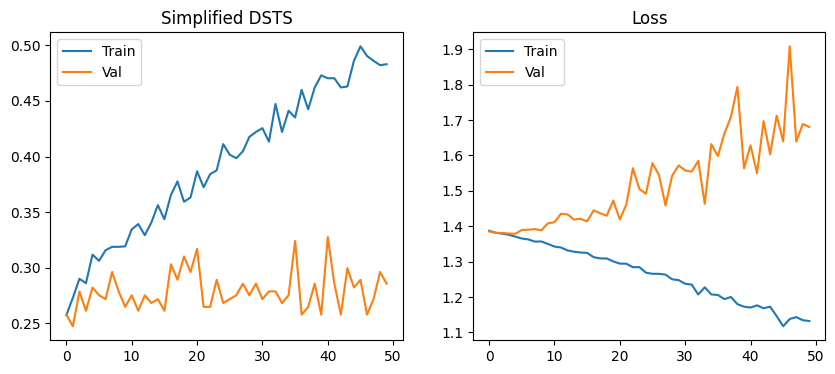


🎯 Simplified DSTS accuracy: 28.57%


In [9]:
# ============================================================
# TRAIN SIMPLIFIED DSTS
# ============================================================

DATA_DIR = "/content/drive/MyDrive/chimera_v2.0/data/bcic4_2a_processed/"
MODEL_SAVE_DIR = "/content/drive/MyDrive/chimera_v2.0/models/"

# Load data
from eegencoder.train import get_loso_dataloaders
train_loader, test_loader = get_loso_dataloaders(DATA_DIR, test_subject=2, batch_size=32)

# Amplify (critical)
train_loader.dataset.tensors = (train_loader.dataset.tensors[0] * 5000, train_loader.dataset.tensors[1])
test_loader.dataset.tensors = (test_loader.dataset.tensors[0] * 5000, test_loader.dataset.tensors[1])

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = get_model_simple(num_classes=4).to(device)

print(f"🧠 Training Simplified DSTS")
print(f"Parameters: {sum(p.numel() for p in model.parameters())/1e6:.2f}M")
print(f"Data range: [{train_loader.dataset.tensors[0].min():.3f}, {train_loader.dataset.tensors[0].max():.3f}]\n")

# Hyperparameters from BlackCattt9's paper
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-3)  # Lower LR, higher WD
criterion = nn.CrossEntropyLoss()

# Training loop
history = {'train': [], 'val': []}
best_acc = 0.0

for epoch in range(1, 51):  # More epochs
    # Train
    model.train()
    train_correct = 0
    train_loss = 0

    for data, target in train_loader:
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        train_correct += (output.argmax(1) == target).sum().item()
        train_loss += loss.item()

    train_acc = train_correct / len(train_loader.dataset)
    train_loss = train_loss / len(train_loader)

    # Validate
    model.eval()
    val_correct = 0
    val_loss = 0

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)

            val_correct += (output.argmax(1) == target).sum().item()
            val_loss += loss.item()

    val_acc = val_correct / len(test_loader.dataset)
    val_loss = val_loss / len(test_loader)

    history['train'].append({'accuracy': train_acc, 'loss': train_loss})
    history['val'].append({'accuracy': val_acc, 'loss': val_loss})

    if val_acc > best_acc:
        best_acc = val_acc
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'accuracy': best_acc
        }, f"{MODEL_SAVE_DIR}/simple_dsts_subject02_best.pth")

    if epoch % 5 == 0:
        print(f"Epoch {epoch:02d}/50 | Train: {train_acc:.4f} | Val: {val_acc:.4f} | Best: {best_acc:.4f}")

# Plot
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot([h['accuracy'] for h in history['train']], label='Train')
plt.plot([h['accuracy'] for h in history['val']], label='Val')
plt.title('Simplified DSTS')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot([h['loss'] for h in history['train']], label='Train')
plt.plot([h['loss'] for h in history['val']], label='Val')
plt.title('Loss')
plt.legend()
plt.show()

final_acc = history['val'][-1]['accuracy']
print(f"\n🎯 Simplified DSTS accuracy: {final_acc*100:.2f}%")